# Set up

In [4]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import scipy.interpolate as interp
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [6]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [7]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,Us,U0s,U1s,Ys,rs,ds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd = pickle.load(file)

In [8]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
conditions = ['0','0.25','0.5','0.75','1']
# conditions = ['0:1','1:3','1:1','3:1','1:0']
# conditions = ['0:1','1:3','1:1','3:1','1:0']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


## feedforward feedback

In [ ]:
def FF_FB(Tur,Tud):
    B = - (1 / M) * (Tud / (1+ Tud)) 
    F = (1 + B * M)*Tur - B
    return F,B
def FF_FB_each_modality(Tu0r,Tu0d,Tu1r,Tu1d,w): #w = weighting of EMG
    w0 = w
    w1 = 1-w
    B0 = (- (1/M) * Tu0d) / (1 + w0*Tu0d + w1*Tu1d)
    B1 = (- (1/M) * Tu1d) / (1 + w0*Tu0d + w1*Tu1d)
    F0 = -B0 + Tu0r + w0 * B0 * M * Tu0r + w1 * B0 * M * Tu1r
    F1 = -B1 + Tu1r + w0 * B1 * M * Tu0r + w1 * B1 * M * Tu1r
    return F0,F1,B0,B1

F = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        for i in range(trial_num//2):
            F[sub,cond,i],B[sub,cond,i] = FF_FB(Tur[sub,cond,i],Tud[sub,cond,i])
print(F.shape) # subject x condition x trial//2 x stimulated freqs
print(B.shape)

F0 = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
F1 = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B0 = np.zeros(Tur.shape, dtype=complex)
B1 = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        w = alphas[cond]
        for i in range(trial_num//2):
            F0[sub,cond,i],F1[sub,cond,i],B0[sub,cond,i],B1[sub,cond,i] \
                = FF_FB_each_modality(Tu0r[sub,cond,i],Tu0d[sub,cond,i],Tu1r[sub,cond,i],Tu1d[sub,cond,i],w)
print(F0.shape) # subject x condition x trial//2 x stimulated freqs
print(B0.shape)

In [ ]:
sub = 0
cond = 2
trial = 0
print(F[sub,cond,trial])
print((F0[sub,cond,trial]+F1[sub,cond,trial])/2)

# Performance

## time domain

In [137]:
datas = []
last_trials = 10
for cond in range(condition_num):
    datas.append( np.mean((rs[:,cond,-last_trials:] - ys[:,cond,-last_trials:])**2,axis = (1,2)) )#mean across all trials and timestamps

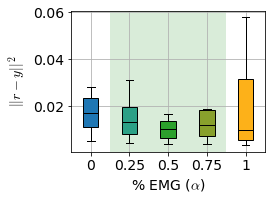

In [138]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||r-y||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [139]:
WilcoxonTest(datas)

(array([nan, 14., 14., 29., 40., 14., nan, 31., 54., 57., 14., 31., nan,
        19., 38., 29., 54., 19., nan, 54., 40., 57., 38., 54., nan]),
 array([       nan, 0.00671387, 0.00671387, 0.08325195, 0.27685547,
        0.00671387,        nan, 0.10699463, 0.76153564, 0.89038086,
        0.00671387, 0.10699463,        nan, 0.01806641, 0.22930908,
        0.08325195, 0.76153564, 0.01806641,        nan, 0.76153564,
        0.27685547, 0.89038086, 0.22930908, 0.76153564,        nan]),
 array([nan,  1.,  1.,  0.,  0.,  1., nan,  0.,  0.,  0.,  1.,  0., nan,
         1.,  0.,  0.,  0.,  1., nan,  0.,  0.,  0.,  0.,  0., nan]),
 ['there is significant difference between condition 0 and condition 1, w = 14.0, pvalue = 0.0067138671875',
  'there is significant difference between condition 0 and condition 2, w = 14.0, pvalue = 0.0067138671875',
  'there is significant difference between condition 2 and condition 3, w = 19.0, pvalue = 0.01806640625'])

## freq domain

In [201]:
print(xf[xf<=0.25])
index_below = 11 # index of freqs below crossover of 0.25Hz
stim_below = 3 # index of stimulated freqs below crossover of 0.25Hz
index_below_nonstim = np.array([0,1,2,3,5,7,8,9]) # index of non-stim freqs below crossover of 0.25Hz

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]


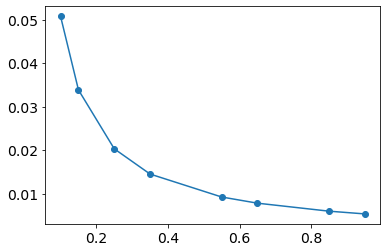

In [203]:
Stimuli = np.zeros(IX.shape,dtype = complex)
Stimuli[::2] = Rs[0,0,-1,IX][::2]
Stimuli[1::2] = Rs[0,0,-2,IX][1::2]

plt.plot(freqs,np.abs(Stimuli),'-o')

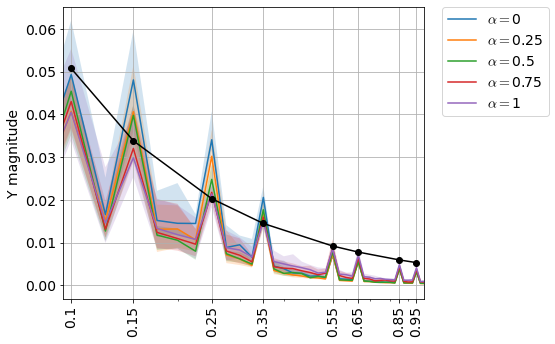

In [209]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

TF = Ys[:,:,:,:N//2]

fig,ax = plt.subplots(sharex=True,figsize=(8,5))
for cond in range(condition_num):
    mean = np.mean(np.abs(TF[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax.plot(xf,q50,'-',label = r'$\alpha = $'+conditions[cond])
    ax.fill_between(xf, q25, q75, alpha=0.2)
ax.plot(freqs,np.abs(Stimuli),'-o',color = 'black')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
# ax.set_yscale("log")
ax.set_ylabel('Y magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# ax.set_title('Non-stim frequencies (N = 15)')
plt.tight_layout()
plt.show()

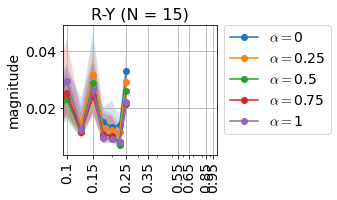

In [202]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

last_trials = 10
TF = Rs[:,:,-last_trials:,:index_below] - Ys[:,:,-last_trials:,:index_below] # R-Y below 0.25 Hz, all freqs

fig,ax = plt.subplots(sharex=True,figsize=(5,3))
for cond in range(condition_num):
    mean = np.mean(np.abs(TF[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax.plot(xf[:index_below],q50,'-o',label = r'$\alpha = $'+conditions[cond])
    ax.fill_between(xf[:index_below], q25, q75, alpha=0.2)
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
# ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title('R-Y (N = 15)')
plt.tight_layout()
plt.show()

In [155]:
datas = []
last_trials = 10

TF = Rs[:,:,-last_trials:,:index_below] - Ys[:,:,-last_trials:,:index_below] # R-Y below 0.25 Hz, all freqs
# TF = Rs[:,:,-last_trials:,index_below_nonstim] - Ys[:,:,-last_trials:,index_below_nonstim] # R-Y non-stim below 0.25 Hz, all freqs
# TF = Rs[:,:,-last_trials:,IX[:stim_below]] - Ys[:,:,-last_trials:,IX[:stim_below]]# R-Y stim below 0.25 Hz, all freqs
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs

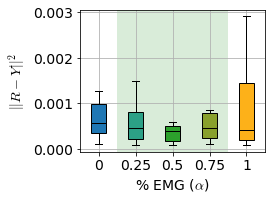

In [156]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||R-Y||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [157]:
WilcoxonTest(datas)

(array([nan, 37., 25., 46., 53., 37., nan, 39., 47., 47., 25., 39., nan,
        17., 30., 46., 47., 17., nan, 57., 53., 47., 30., 57., nan]),
 array([       nan, 0.20776367, 0.0479126 , 0.45428467, 0.71972656,
        0.20776367,        nan, 0.25238037, 0.4887085 , 0.4887085 ,
        0.0479126 , 0.25238037,        nan, 0.01245117, 0.09460449,
        0.45428467, 0.4887085 , 0.01245117,        nan, 0.89038086,
        0.71972656, 0.4887085 , 0.09460449, 0.89038086,        nan]),
 array([nan,  0.,  1.,  0.,  0.,  0., nan,  0.,  0.,  0.,  1.,  0., nan,
         1.,  0.,  0.,  0.,  1., nan,  0.,  0.,  0.,  0.,  0., nan]),
 ['there is significant difference between condition 0 and condition 2, w = 25.0, pvalue = 0.04791259765625',
  'there is significant difference between condition 2 and condition 3, w = 17.0, pvalue = 0.012451171875'])

## Tyr - 1

In [253]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = Tyr[:,:,-last_trials:,:stim_below] - 1 #at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs

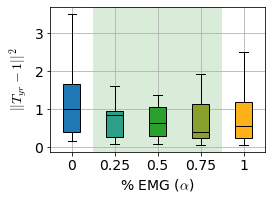

In [254]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||T_{yr} - 1||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [255]:
WilcoxonTest(datas)

(array([nan, 16., 12., 22., 17., 16., nan, 32., 42., 59., 12., 32., nan,
        49., 49., 22., 42., 49., nan, 55., 17., 59., 49., 55., nan]),
 array([       nan, 0.01025391, 0.00427246, 0.03015137, 0.01245117,
        0.01025391,        nan, 0.12054443, 0.33026123, 0.97796631,
        0.00427246, 0.12054443,        nan, 0.56140137, 0.56140137,
        0.03015137, 0.33026123, 0.56140137,        nan, 0.80395508,
        0.01245117, 0.97796631, 0.56140137, 0.80395508,        nan]),
 array([nan,  1.,  1.,  1.,  1.,  1., nan,  0.,  0.,  0.,  1.,  0., nan,
         0.,  0.,  1.,  0.,  0., nan,  0.,  1.,  0.,  0.,  0., nan]),
 ['there is significant difference between condition 0 and condition 1, w = 16.0, pvalue = 0.01025390625',
  'there is significant difference between condition 0 and condition 2, w = 12.0, pvalue = 0.0042724609375',
  'there is significant difference between condition 0 and condition 3, w = 22.0, pvalue = 0.0301513671875',
  'there is significant difference between cond

## Tyd

In [275]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = Tyd[:,:,-last_trials:,:stim_below] # Tyd at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs

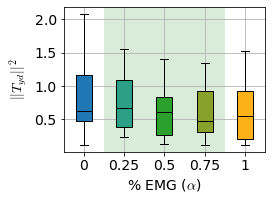

In [276]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||T_{yd}||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [277]:
WilcoxonTest(datas)

(array([nan, 45., 33., 36., 31., 45., nan, 53., 41., 51., 33., 53., nan,
        57., 54., 36., 41., 57., nan, 56., 31., 51., 54., 56., nan]),
 array([       nan, 0.42120361, 0.13537598, 0.18762207, 0.10699463,
        0.42120361,        nan, 0.71972656, 0.30279541, 0.63867188,
        0.13537598, 0.71972656,        nan, 0.89038086, 0.76153564,
        0.18762207, 0.30279541, 0.89038086,        nan, 0.84692383,
        0.10699463, 0.63867188, 0.76153564, 0.84692383,        nan]),
 array([nan,  0.,  0.,  0.,  0.,  0., nan,  0.,  0.,  0.,  0.,  0., nan,
         0.,  0.,  0.,  0.,  0., nan,  0.,  0.,  0.,  0.,  0., nan]),
 [])

## F-M-1

In [53]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = F[:,:,-last_trials:,:stim_below] - (M**(-1))[:stim_below] # at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs

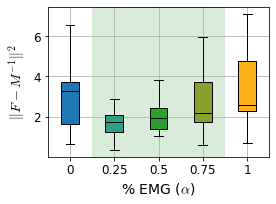

In [54]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||F-M^{-1}||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [50]:
WilcoxonTest(datas)

(array([nan, 23., 26., 55., 40., 23., nan, 49., 30.,  9., 26., 49., nan,
        39., 23., 55., 30., 39., nan, 35., 40.,  9., 23., 35., nan]),
 array([       nan, 0.03533936, 0.05535889, 0.80395508, 0.27685547,
        0.03533936,        nan, 0.56140137, 0.09460449, 0.00201416,
        0.05535889, 0.56140137,        nan, 0.25238037, 0.03533936,
        0.80395508, 0.09460449, 0.25238037,        nan, 0.16882324,
        0.27685547, 0.00201416, 0.03533936, 0.16882324,        nan]),
 array([nan,  1.,  0.,  0.,  0.,  1., nan,  0.,  0.,  1.,  0.,  0., nan,
         0.,  1.,  0.,  0.,  0., nan,  0.,  0.,  1.,  1.,  0., nan]),
 ['there is significant difference between condition 0 and condition 1, w = 23.0, pvalue = 0.03533935546875',
  'there is significant difference between condition 1 and condition 4, w = 9.0, pvalue = 0.00201416015625',
  'there is significant difference between condition 2 and condition 4, w = 23.0, pvalue = 0.03533935546875'])

# Inputs of modalities

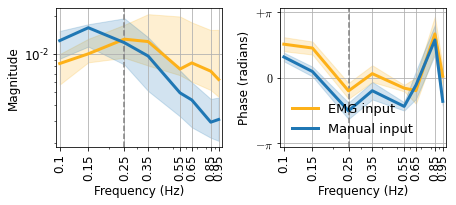

In [62]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

cond = 2
last_trials = 10
fig,axs = plt.subplots(1,2,sharex=True,figsize=(6.5,3))

# magnitude
ax = axs[0]
ax.axvline(x=0.25, color='grey', linestyle='--')
U0_mean = np.mean(np.abs(U0s[:,cond,-last_trials:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(freqs,q50,'-',label = 'EMG input',color = colors['GOLD'],linewidth = 3)
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])

U1_mean = np.mean(np.abs(U1s[:,cond,-last_trials:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(freqs,q50,'-',label = 'Manual input',color = colors['BLUE'],linewidth = 3)
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])

ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('Magnitude')
ax.set_xlabel('Frequency (Hz)')

# phase
ax = axs[1]
ax.axvline(x=0.25, color='grey', linestyle='--')
angles = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,-last_trials:,:][:,:,IX]))),axis = 1))
z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = 'EMG input',color = colors['GOLD'],linewidth = 3)
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

angles = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,-last_trials:,:][:,:,IX]))),axis = 1))
z = np.mean(np.exp(1j*(angles)), axis=0)
mean = np.angle(z)
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = 'Manual input',color = colors['BLUE'],linewidth = 3)
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

ax.set_ylabel('Phase (radians)') 
ax.grid('on',zorder=-1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('Frequency (Hz)')
ax.legend(loc = 'lower left',frameon=False, fontsize = 13)
# axs[0].legend(bbox_to_anchor=(1., 1.3),frameon=False, ncol = 2)
plt.tight_layout()
# fig.savefig('multimodal_inputs.svg')
plt.show()

## non stim freq inputs

In [17]:
nonstim_freqs = np.delete(xf, IX)
UXs = np.delete(Us[:,:,:,:N//2], IX,axis = 3)
U0Xs = np.delete(U0s[:,:,:,:N//2], IX,axis = 3)
U1Xs = np.delete(U1s[:,:,:,:N//2], IX,axis = 3)
UXs.shape

(15, 5, 14, 1192)

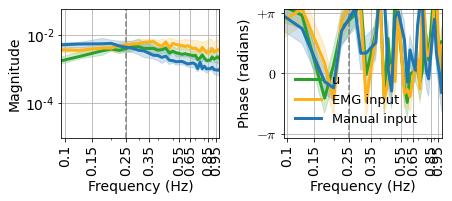

In [18]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

cond = 2
fig,axs = plt.subplots(1,2,sharex=True,figsize=(6.5,3))

# magnitude
ax = axs[0]
ax.axvline(x=0.25, color='grey', linestyle='--')
U_mean = np.mean(np.abs(UXs[:,cond,:,:]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(nonstim_freqs,q50,'-',label = 'u',color = colors['GREEN'],linewidth = 3)
ax.fill_between(nonstim_freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

U0_mean = np.mean(np.abs(U0Xs[:,cond,:,:]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(nonstim_freqs,q50,'-',label = 'EMG input',color = colors['GOLD'],linewidth = 3)
ax.fill_between(nonstim_freqs, q25, q75, alpha=0.2,color = colors['GOLD'])

U1_mean = np.mean(np.abs(U1Xs[:,cond,:,:]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(nonstim_freqs,q50,'-',label = 'Manual input',color = colors['BLUE'],linewidth = 3)
ax.fill_between(nonstim_freqs, q25, q75, alpha=0.2,color = colors['BLUE'])

ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('Magnitude')
ax.set_xlabel('Frequency (Hz)')

# phase
ax = axs[1]
ax.axvline(x=0.25, color='grey', linestyle='--')
angles = np.angle(np.mean(np.exp(1j*(np.angle(UXs[:,cond,:,:]))),axis = 1))
z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(nonstim_freqs,mean,'-',label = 'u',color = colors['GREEN'],linewidth = 3)
ax.fill_between(nonstim_freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

angles = np.angle(np.mean(np.exp(1j*(np.angle(U0Xs[:,cond,:,:]))),axis = 1))
z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(nonstim_freqs,mean,'-',label = 'EMG input',color = colors['GOLD'],linewidth = 3)
ax.fill_between(nonstim_freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

angles = np.angle(np.mean(np.exp(1j*(np.angle(U1Xs[:,cond,:,:]))),axis = 1))
z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(nonstim_freqs,mean,'-',label = 'Manual input',color = colors['BLUE'],linewidth = 3)
ax.fill_between(nonstim_freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

ax.set_ylabel('Phase (radians)') 
ax.grid('on',zorder=-1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('Frequency (Hz)')
ax.legend(loc = 'lower left',frameon=False, fontsize = 13)
# axs[0].legend(bbox_to_anchor=(1., 1.3),frameon=False, ncol = 2)
plt.tight_layout()
# fig.savefig('multimodal_inputs.svg')
plt.show()

## effect of ux

In [322]:
UXs_ = Us
UXs_[:,:,:,IX] = 0 # replace the stimulated inputs with 0

M_all = soM(s(2*np.pi*xf_all)) #machine at all freqs #s = jw = j(2pif)  #2nd order machine
YXs = M_all*UXs_
YXs[:,:,:,0] = 0 # replace the nan with 0
YXs.shape

c:\Users\amber\Documents\GitHub\sensorimotor_fusion\analysis\Multimodal paper\globalVars.py:29: RuntimeWarning: divide by zero encountered in true_divide
  soM = lambda s : 1/(s**2 + s) #2nd order machine
c:\Users\amber\Documents\GitHub\sensorimotor_fusion\analysis\Multimodal paper\globalVars.py:29: RuntimeWarning: invalid value encountered in true_divide
  soM = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-322-9f408babf4fd>:5: RuntimeWarning: invalid value encountered in multiply
  YXs = M_all*UXs_


(15, 5, 14, 2400)

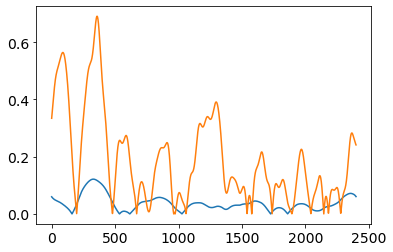

In [328]:
from scipy import fft
yx = (fft.ifft(YXs)*N).real
plt.plot(np.abs(yx[0,0,0]))
plt.plot(np.abs(rs[0,0,0] - ys[0,0,0]))

In [334]:
# total error and non-stim error #(np.sum(abs(refs - outs)**2))
total_error = np.sum(np.abs(rs[0,0,0] - ys[0,0,0])**2)
nonstim_error = np.sum(np.abs(yx[0,0,0])**2)
print(total_error, nonstim_error)
ratio = nonstim_error / total_error
print(ratio)

143.9453715841665 5.040414806127423
0.035016164470284716


In [346]:
for cond in range(condition_num):
    total_error = np.median(np.sum(np.abs(rs[:,cond,-4:] - ys[:,cond,-4:])**2,axis = 2)) # mean across subjects and trials
    nonstim_error = np.median(np.sum(np.abs(yx[:,cond,-4:])**2,axis = 2))
    ratio = nonstim_error / total_error
    # print(nonstim_error,total_error)
    print(ratio)

0.026483286009411904
0.024010416568233526
0.02309175416343072
0.02557137504575726
0.031584641657649196


# Feedforward and Feedback

## F and B at nonstim freq (interp)

In [71]:
def lessthanone(x): return x < 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)] #index 0~39
len(indexone)

40

In [72]:
new_indices = np.arange(4, 39)  # All integer indices between min and max
new_indices

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38])

In [73]:
F0interp = np.zeros((subject_num,condition_num,trial_num//2,len(new_indices)),dtype = complex)
F1interp = np.zeros((subject_num,condition_num,trial_num//2,len(new_indices)),dtype = complex)
B0interp = np.zeros((subject_num,condition_num,trial_num//2,len(new_indices)),dtype = complex)
B1interp = np.zeros((subject_num,condition_num,trial_num//2,len(new_indices)),dtype = complex)
# for TF in [F0,F1,B0,B1]:
for sub in range(subject_num):
    for cond in range(condition_num):
        for trial in range(trial_num//2):
            TF = F0
            complex_values = TF[sub,cond,trial]
            real = interp.interp1d(IX,complex_values.real, kind = 'linear')
            imag = interp.interp1d(IX,complex_values.imag, kind = 'linear')
            new_real = real(new_indices)
            new_imag = imag(new_indices)
            F0interp[sub,cond,trial] = new_real + 1j * new_imag

            TF = F1
            complex_values = TF[sub,cond,trial]
            real = interp.interp1d(IX,complex_values.real, kind = 'linear')
            imag = interp.interp1d(IX,complex_values.imag, kind = 'linear')
            new_real = real(new_indices)
            new_imag = imag(new_indices)
            F1interp[sub,cond,trial] = new_real + 1j * new_imag

            TF = B0
            complex_values = TF[sub,cond,trial]
            real = interp.interp1d(IX,complex_values.real, kind = 'linear')
            imag = interp.interp1d(IX,complex_values.imag, kind = 'linear')
            new_real = real(new_indices)
            new_imag = imag(new_indices)
            B0interp[sub,cond,trial] = new_real + 1j * new_imag

            TF = B1
            complex_values = TF[sub,cond,trial]
            real = interp.interp1d(IX,complex_values.real, kind = 'linear')
            imag = interp.interp1d(IX,complex_values.imag, kind = 'linear')
            new_real = real(new_indices)
            new_imag = imag(new_indices)
            B1interp[sub,cond,trial] = new_real + 1j * new_imag
F0interp.shape

(15, 5, 7, 35)

## sensorimotor noise

In [93]:
nonstim_indices = np.delete(new_indices, IX-4)
nonstim_indices

array([ 5,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25,
       27, 28, 29, 30, 31, 32, 33, 35, 36, 37])

In [102]:
M_all = soM(s(2*np.pi*xf)) #machine at all freqs #s = jw = j(2pif)  #2nd order machine
M_all[0] = 0
Minterp = M_all[nonstim_indices] #machine at non-stimulated freqs
Minterp.shape

c:\Users\amber\Documents\GitHub\sensorimotor_fusion\analysis\Multimodal paper\globalVars.py:29: RuntimeWarning: divide by zero encountered in true_divide
  soM = lambda s : 1/(s**2 + s) #2nd order machine
c:\Users\amber\Documents\GitHub\sensorimotor_fusion\analysis\Multimodal paper\globalVars.py:29: RuntimeWarning: invalid value encountered in true_divide
  soM = lambda s : 1/(s**2 + s) #2nd order machine


(27,)

In [108]:
delta0 = np.zeros((subject_num,condition_num,trial_num,len(Minterp)),dtype = complex)
delta1 = np.zeros((subject_num,condition_num,trial_num,len(Minterp)),dtype = complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        for trial in [0, 2, 4, 6, 8, 10, 12]: #even trial 
            delta0[sub,cond,trial] = U0s[sub,cond,trial,nonstim_indices] - np.delete(B0interp[sub,cond,trial//2],IX-4)*Minterp*Us[sub,cond,trial,nonstim_indices]
            delta1[sub,cond,trial] = U1s[sub,cond,trial,nonstim_indices] - np.delete(B1interp[sub,cond,trial//2],IX-4)*Minterp*Us[sub,cond,trial,nonstim_indices]
        for trial in [1, 3, 5, 7, 9, 11, 13]: #odd trials 
            delta0[sub,cond,trial] = U0s[sub,cond,trial,nonstim_indices] - np.delete(B0interp[sub,cond,trial//2],IX-4)*Minterp*Us[sub,cond,trial,nonstim_indices]
            delta1[sub,cond,trial] = U1s[sub,cond,trial,nonstim_indices] - np.delete(B1interp[sub,cond,trial//2],IX-4)*Minterp*Us[sub,cond,trial,nonstim_indices]
delta0.shape            

(15, 5, 14, 27)

In [112]:
datas = []
last_trials = 10
stim_below = 5 # below crossover 

TF = delta1[:,:,-last_trials:,:stim_below] # at nonstim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs

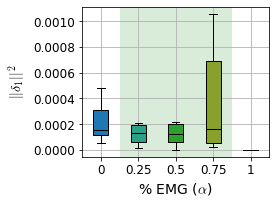

In [113]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||\delta_1||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

## F B bode plots

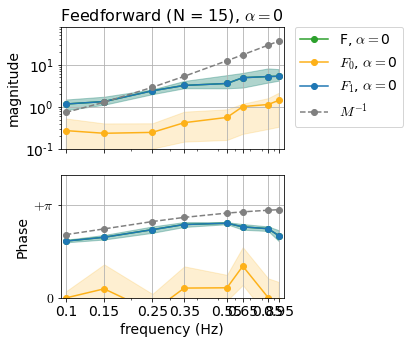

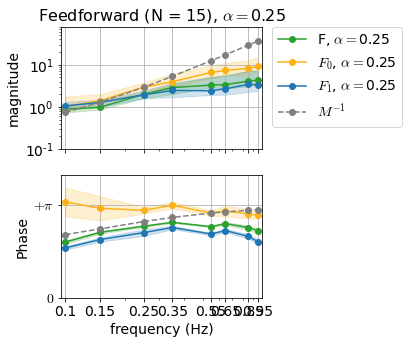

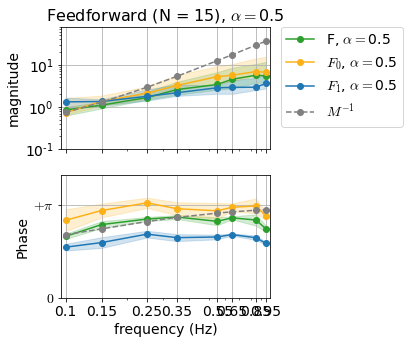

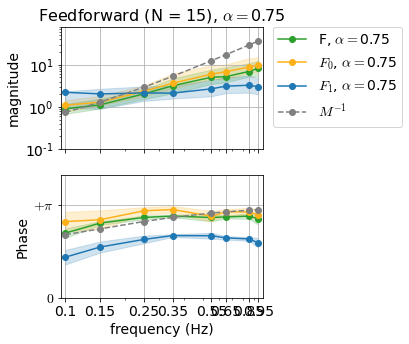

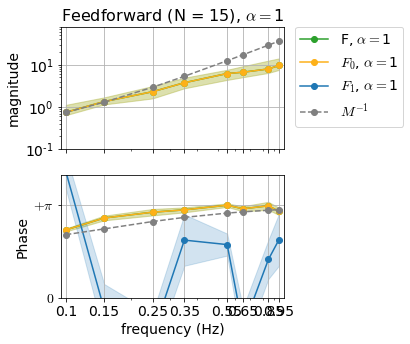

In [279]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(6,5))
    # F
    mean = np.mean(np.abs(F[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'F, $\alpha = $'+conditions[cond],color = colors['GREEN'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GREEN'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

    # F0
    F_mean = np.mean(np.abs(F0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(F1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

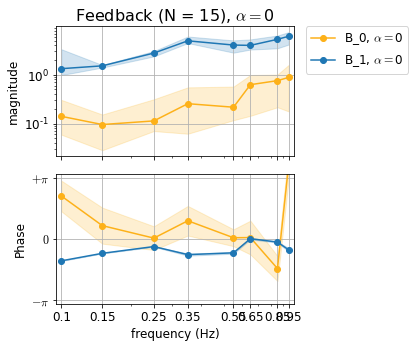

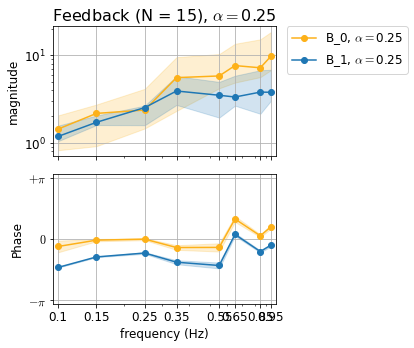

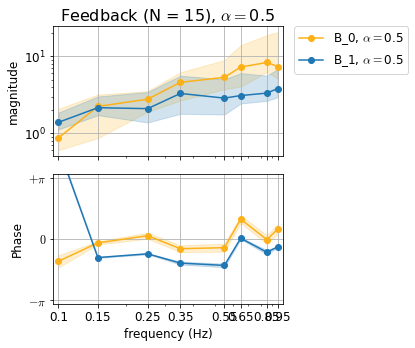

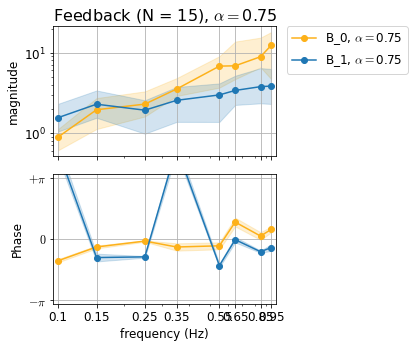

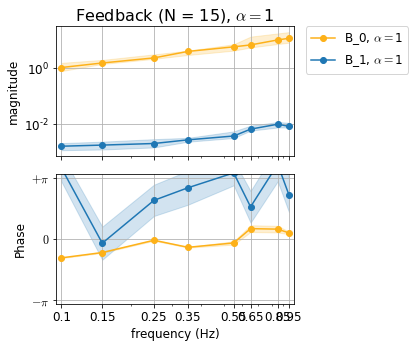

In [533]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(6,5))

    # F0
    F_mean = np.mean(np.abs(B0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'B_0, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(B1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'B_1, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax = axs[0]
    # ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    # ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedback (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

In [538]:
diff = B0[:,cond,:,:] / B1[:,cond,:,:]
diff.shape

(15, 7, 8)

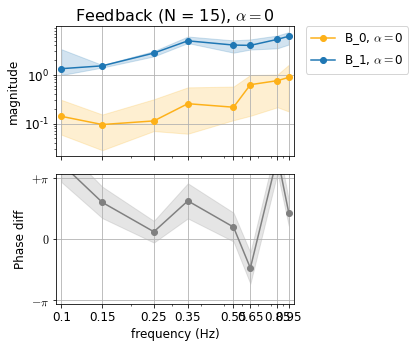

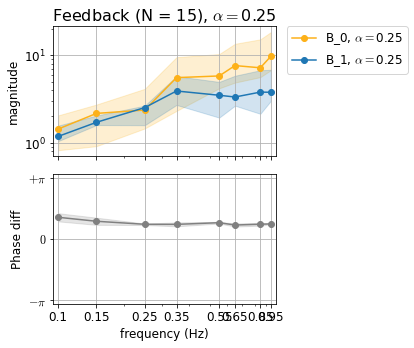

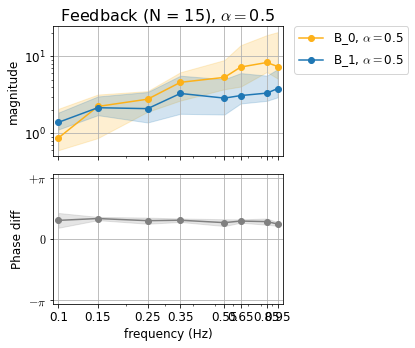

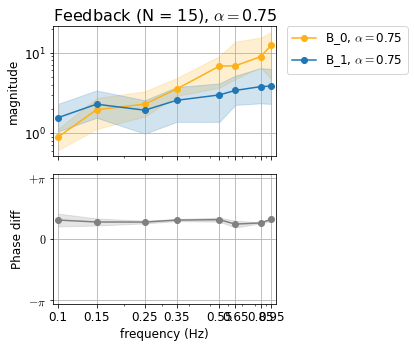

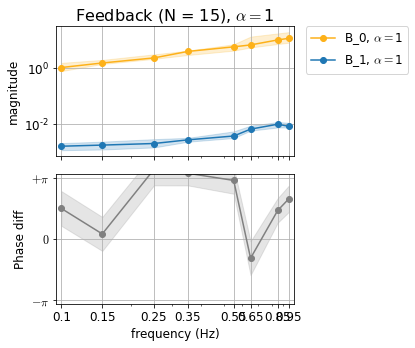

In [540]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(6,5))

    # F0
    F_mean = np.mean(np.abs(B0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'B_0, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(B1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'B_1, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])

    # phase difference    
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[:,cond,:,:] / B1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = 'grey')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'grey')

    ax = axs[0]
    # ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    # ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase diff') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedback (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

## Bode plot (interp)

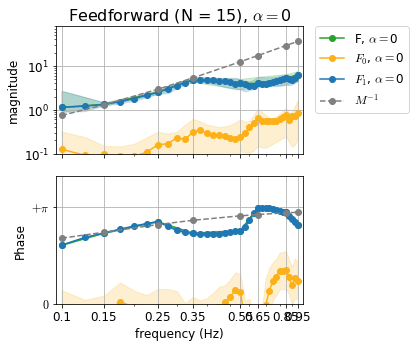

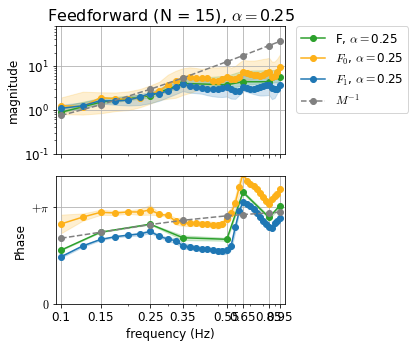

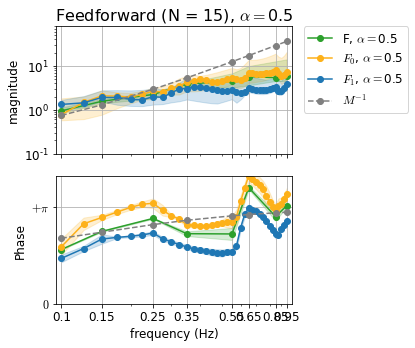

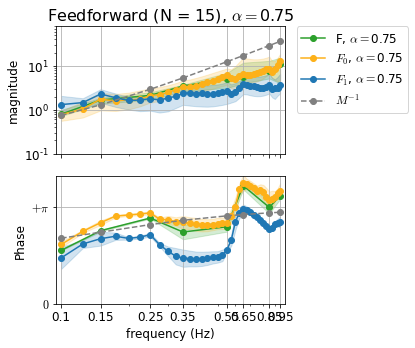

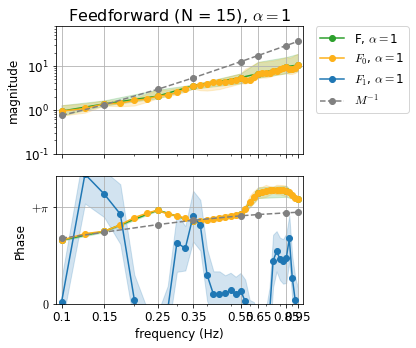

In [525]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(6,5))
    # F
    mean = np.mean(np.abs(F[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'F, $\alpha = $'+conditions[cond],color = colors['GREEN'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GREEN'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

    # F0
    F_mean = np.mean(np.abs(F0interp[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(xf[new_indices],q50,'-o',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(xf[new_indices], q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0interp[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(xf[new_indices],mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(xf[new_indices],mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(F1interp[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(xf[new_indices],q50,'-o',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(xf[new_indices], q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1interp[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(xf[new_indices],mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(xf[new_indices],mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

# Individaul strategies

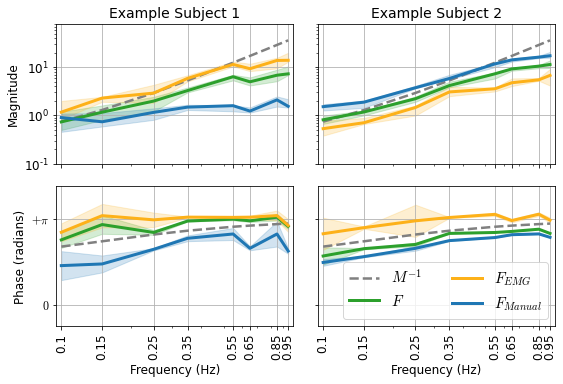

In [67]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi/4, np.pi+1.2)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']
cond = 2

fig,axs = plt.subplots(2,2,sharex = 'col', sharey = 'row',figsize=(8,5.5))

for i,sub in enumerate([10,6]):
    # magnitude
    ax = axs[0,i]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$',linewidth = 2.5)
    
    mean, q25,q50,q75 = mean_and_interquartile(np.abs(F[sub,cond,:,:]), axis = 0) #across all trials
    ax.plot(freqs,q50,'-',label = 'Feedforward (combined)',color = colors['GREEN'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

    mean, q25,q50,q75 = mean_and_interquartile(np.abs(F0[sub,cond,:,:]), axis = 0) #across all trials
    ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

    mean, q25,q50,q75 = mean_and_interquartile(np.abs(F1[sub,cond,:,:]), axis = 0) #across all trials
    ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    
    # phase
    ax = axs[1,i]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)

    angle = np.mean(np.exp(1j*(np.angle(F[sub,cond,:,:])-np.pi/2)),axis = 0)
    mean = np.angle(angle)+np.pi/2
    disp = 1 - np.abs(angle)
    ax.plot(freqs,mean,'-',label = r'$F$',color = colors['GREEN'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

    angle = np.mean(np.exp(1j*(np.angle(F0[sub,cond,:,:])-np.pi/2)),axis = 0)
    mean = np.angle(angle)+np.pi/2
    disp = 1 - np.abs(angle)
    ax.plot(freqs,mean,'-',label = r'$F_{EMG}$',color = colors['GOLD'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    angle = np.mean(np.exp(1j*(np.angle(F1[sub,cond,:,:])-np.pi/2)),axis = 0)
    mean = np.angle(angle)+np.pi/2
    disp = 1 - np.abs(angle)
    ax.plot(freqs,mean,'-',label = r'$F_{Manual}$',color = colors['BLUE'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('Frequency (Hz)')

axs[1,0].set_xticks(xticks)
axs[1,0].set_xticklabels(xticks,rotation=90) 
axs[1,1].set_xticks(xticks)
axs[1,1].set_xticklabels(xticks,rotation=90) 
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase (radians)')
axs[1,1].legend(loc='lower right', ncol = 2,fontsize = 15)
# axs[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False,fontsize = 12)
axs[0,0].set_title('Example Subject 1',fontsize = 14)
axs[0,1].set_title('Example Subject 2',fontsize = 14)
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
plt.tight_layout()
fig.savefig('example_subjects.svg')
plt.show()

## individual performance (time domain)

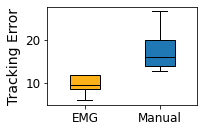

In [68]:
labels = ['EMG','Manual'] #slider : EMG
boxcolors = [colors['GOLD'],colors['BLUE']]

sub = 10 # example subject 1
avg_error_slider = errors[sub,0,-4:] # slider only condition, last 4 trials
avg_error_emg = errors[sub,4,-4:] # emg only condition, last 4 trials
datas = [avg_error_emg,avg_error_slider]
# yticks = [0.,50,100]

fig,ax = plt.subplots(figsize=(3,2))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel(r'$\alpha$',fontsize = 14) #add x axis labels
# ax.set_ylim(0,100) # set y axis limit
# ax.set_yticks(yticks) #set y axis ticks
# ax.set_title('Example Subject 1',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.tight_layout()
fig.savefig('example_sub1.svg')
plt.show()

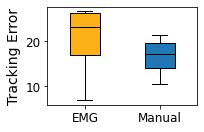

In [69]:
labels = ['EMG','Manual'] #slider : EMG
boxcolors = [colors['GOLD'],colors['BLUE']]

sub = 6 # example subject 1
avg_error_slider = errors[sub,0,-4:] # slider only condition, last 4 trials
avg_error_emg = errors[sub,4,-4:] # emg only condition, last 4 trials 
datas = [avg_error_emg,avg_error_slider]
# yticks = [0.,50,100]

fig,ax = plt.subplots(figsize=(3,2))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel(r'$\alpha$',fontsize = 14) #add x axis labels
# ax.set_ylim(0,100) # set y axis limit
# ax.set_yticks(yticks) #set y axis ticks
# ax.set_title('Example Subject 2',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.tight_layout()
fig.savefig('example_sub2.svg')
plt.show()

# Group people's better modality

In [63]:
avg_errors_slider = np.mean(errors[:,0,-4:],axis = 1) # slider only condition, last 4 trials
avg_errors_emg = np.mean(errors[:,4,-4:],axis = 1) # emg only condition, last 4 trials 
avg_errors_slider,avg_errors_emg

(array([ 24.61358698,  74.67738171,  39.14504844,  41.79853006,
         98.83679008,  12.38954531,  16.54242273,  33.30467105,
         19.63313128,  44.64789093,  17.87806994,  38.7626948 ,
         19.213824  , 101.5626955 ,  40.17109438]),
 array([ 20.38982803, 633.14936659,  27.43209348,  18.60563704,
        177.14268977,   8.71005092,  19.9220363 ,  32.73341267,
          6.50489251, 104.83528429,  10.86552922,  14.78921974,
         14.43955604,  29.9748155 ,   9.30384281]))

In [64]:
# find who is better at which modality
slider_experts = []
emg_experts = []
both_experts = []
for sub in range(subject_num):
    diff = avg_errors_emg[sub] - avg_errors_slider[sub]
    if diff > 0 and np.abs(diff) > 4:
        slider_experts.append(sub)
    elif diff < 0 and np.abs(diff) > 4:
        emg_experts.append(sub)
    else:
        both_experts.append(sub)
slider_experts = np.array(slider_experts)
emg_experts = np.array(emg_experts)
both_experts = np.array(both_experts)
# slider_experts = np.argsort(avg_errors_slider)[:5]
# emg_experts = np.argsort(avg_errors_emg)[:5]
slider_experts_num = len(slider_experts)
emg_experts_num = len(emg_experts)
both_experts_num = len(both_experts)    
print('slider experts = ',slider_experts)
print('emg experts = ',emg_experts)
print('both experts = ',both_experts)

slider experts =  [1 4 9]
emg experts =  [ 0  2  3  8 10 11 12 13 14]
both experts =  [5 6 7]


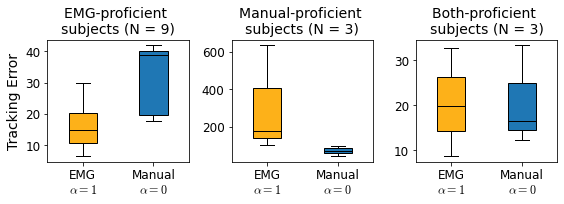

In [65]:
labels = ['EMG''\n'r'$\alpha = 1$','Manual''\n'r'$\alpha = 0$'] #slider : EMG
boxcolors = [colors['GOLD'],colors['BLUE']]
last_few_trials = 4

fig,axs= plt.subplots(1,3,figsize=(8,3))
ax = axs[0]
slider = np.mean(errors[emg_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
emg = np.mean(errors[emg_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [emg,slider]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label

ax = axs[1]
slider = np.mean(errors[slider_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
emg = np.mean(errors[slider_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [emg,slider]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14)

ax = axs[2]
slider = np.mean(errors[both_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
emg = np.mean(errors[both_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [emg,slider]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14) # add title
plt.tight_layout()
# fig.savefig('example_sub2.svg')
plt.show()

## performance of each group

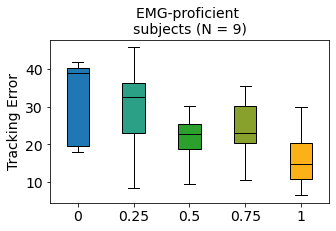

In [284]:
last_few_trials = 4
labels = conditions
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax= plt.subplots(figsize=(5,3))
slider = np.mean(errors[emg_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
multi25 = np.mean(errors[emg_experts,1,-last_few_trials:],axis = 1)  
multi50 = np.mean(errors[emg_experts,2,-last_few_trials:],axis = 1)
multi75 = np.mean(errors[emg_experts,3,-last_few_trials:],axis = 1)
emg = np.mean(errors[emg_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [slider,multi25,multi50,multi75,emg]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label
plt.show()

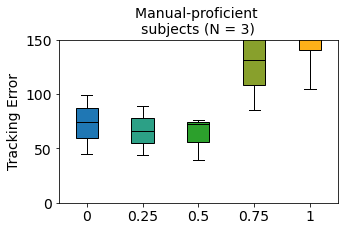

In [285]:
fig,ax= plt.subplots(figsize=(5,3))
slider = np.mean(errors[slider_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
multi25 = np.mean(errors[slider_experts,1,-last_few_trials:],axis = 1)  
multi50 = np.mean(errors[slider_experts,2,-last_few_trials:],axis = 1)
multi75 = np.mean(errors[slider_experts,3,-last_few_trials:],axis = 1)
emg = np.mean(errors[slider_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [slider,multi25,multi50,multi75,emg]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label
ax.set_ylim(0,150)
plt.show()

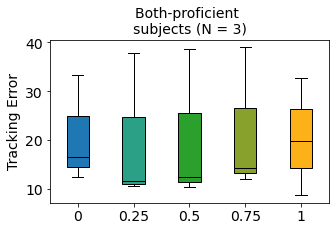

In [286]:
fig,ax= plt.subplots(figsize=(5,3))
slider = np.mean(errors[both_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
multi25 = np.mean(errors[both_experts,1,-last_few_trials:],axis = 1)  
multi50 = np.mean(errors[both_experts,2,-last_few_trials:],axis = 1)
multi75 = np.mean(errors[both_experts,3,-last_few_trials:],axis = 1)
emg = np.mean(errors[both_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [slider,multi25,multi50,multi75,emg]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label
plt.show()

## F0 and F1 of them

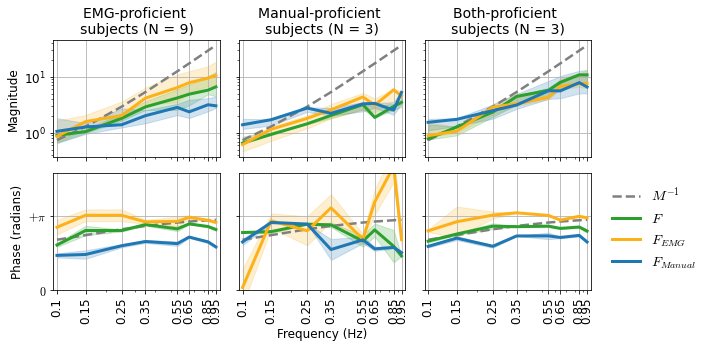

In [70]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1.8)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']
last_few_trials = 5 # cross trials (N//2)

for cond in [2]:
    fig,axs = plt.subplots(2,3,sharex = 'col', sharey = 'row',figsize=(10,5))

    for i,sub in enumerate([emg_experts,slider_experts,both_experts]):
        # magnitude
        ax = axs[0,i]
        ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$',linewidth = 2.5)
        
        mean = np.mean(np.abs(F[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (combined)',color = colors['GREEN'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

        mean = np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

        mean = np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

        ax.set_xscale("log")
        ax.set_xlim(xlim)
        ax.grid('on',zorder=-1)
        # ax.set_ylim(0.1,80)
        ax.set_yscale("log")
        
        # phase
        ax = axs[1,i]
        ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F$',color = colors['GREEN'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F_{EMG}$',color = colors['GOLD'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F_{Manual}$',color = colors['BLUE'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

        ax.grid('on',zorder=-1)
        ax.set_ylim(ylimphase)
        ax.set_yticks(yticksphase)
        ax.set_yticklabels(yticklabelsphase)

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks,rotation=90) 
    axs[1,1].set_xlabel('Frequency (Hz)')
    axs[0,0].set_ylabel('Magnitude')
    axs[1,0].set_ylabel('Phase (radians)')
    # axs[1,1].legend(loc='lower right', ncol = 2,fontsize = 15)
    axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False,fontsize = 14)
    axs[0,0].set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14)
    axs[0,1].set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14)
    axs[0,2].set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14)
    axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
    axs[0,2].get_shared_x_axes().join(axs[0,0], axs[0,1])

    plt.tight_layout()
    # fig.savefig('example_subjects.svg')
    plt.show()

In [127]:
F0[sub,cond,-last_few_trials:,:].shape

(3, 7, 8)

In [129]:
# sub = emg_experts
last_few_trials = 7 # cross trials (N//2)

for i,sub in enumerate([emg_experts,slider_experts,both_experts]):
        data = [np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = (1,2)),
                np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = (1,2))] #mean across trials
        data = np.array(data)
        print(WilcoxonTest(data))

(array([nan,  5.,  5., nan]), array([      nan, 0.0390625, 0.0390625,       nan]), array([nan,  1.,  1., nan]), ['there is significant difference between condition 0 and condition 1, w = 5.0, pvalue = 0.0390625'])
(array([nan,  3.,  3., nan]), array([nan,  1.,  1., nan]), array([nan,  0.,  0., nan]), [])
(array([nan,  3.,  3., nan]), array([nan,  1.,  1., nan]), array([nan,  0.,  0., nan]), [])


In [137]:
# EMG / manual
slider = np.mean(errors[slider_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
emg = np.mean(errors[slider_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
np.mean(emg)/np.mean(slider)

4.194713458589944

In [144]:
cond = 2
sub = slider_experts
mean_emg = np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
mean_slider = np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
np.mean(mean_emg)/np.mean(mean_slider)

0.6657286904336085

## B0 and B1

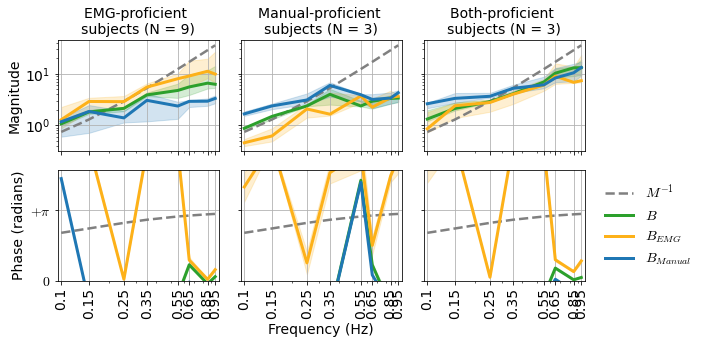

In [148]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1.8)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']
last_few_trials = 7 # cross trials (N//2)

for cond in [2]:
    fig,axs = plt.subplots(2,3,sharex = 'col', sharey = 'row',figsize=(10,5))

    for i,sub in enumerate([emg_experts,slider_experts,both_experts]):
        # magnitude
        ax = axs[0,i]
        ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$',linewidth = 2.5)
        
        mean = np.mean(np.abs(B[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (combined)',color = colors['GREEN'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

        mean = np.mean(np.abs(B0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

        mean = np.mean(np.abs(B1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

        ax.set_xscale("log")
        ax.set_xlim(xlim)
        ax.grid('on',zorder=-1)
        # ax.set_ylim(0.1,80)
        ax.set_yscale("log")
        
        # phase
        ax = axs[1,i]
        ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)

        angle = np.angle(np.mean(np.exp(1j*(np.angle(B[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$B$',color = colors['GREEN'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$B_{EMG}$',color = colors['GOLD'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(B1[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$B_{Manual}$',color = colors['BLUE'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

        ax.grid('on',zorder=-1)
        ax.set_ylim(ylimphase)
        ax.set_yticks(yticksphase)
        ax.set_yticklabels(yticklabelsphase)

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks,rotation=90) 
    axs[1,1].set_xlabel('Frequency (Hz)')
    axs[0,0].set_ylabel('Magnitude')
    axs[1,0].set_ylabel('Phase (radians)')
    # axs[1,1].legend(loc='lower right', ncol = 2,fontsize = 15)
    axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False,fontsize = 14)
    axs[0,0].set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14)
    axs[0,1].set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14)
    axs[0,2].set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14)
    axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
    axs[0,2].get_shared_x_axes().join(axs[0,0], axs[0,1])

    plt.tight_layout()
    # fig.savefig('example_subjects.svg')
    plt.show()

## F0 of emg-experts in emg-only

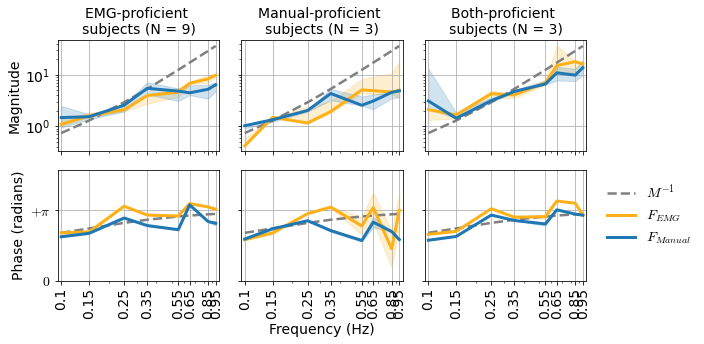

In [134]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1.8)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']

last_few_trials = 4 # cross trials (N//2)

fig,axs = plt.subplots(2,3,sharex = 'col', sharey = 'row',figsize=(10,5))

for i,sub in enumerate([emg_experts,slider_experts,both_experts]):
    # magnitude
    ax = axs[0,i]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$',linewidth = 2.5)
    
    cond = 4 # emg-only
    mean = np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
    ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])
    
    cond = 0 # slider-only
    mean = np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
    ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    
    # phase
    ax = axs[1,i]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)

    cond = 4 # emg-only
    angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
    z = np.mean(np.exp(1j*(angle-np.pi)), axis=0) #mean across subjects
    mean = np.angle(z)+np.pi
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$F_{EMG}$',color = colors['GOLD'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    cond = 0 # slider-only
    angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
    z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$F_{Manual}$',color = colors['BLUE'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase (radians)')
# axs[1,1].legend(loc='lower right', ncol = 2,fontsize = 15)
axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False,fontsize = 14)
axs[0,0].set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14)
axs[0,1].set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14)
axs[0,2].set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14)
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,2].get_shared_x_axes().join(axs[0,0], axs[0,1])

plt.tight_layout()
# fig.savefig('example_subjects.svg')
plt.show()

# difference in perfromance 

In [71]:
avg_errors_slider = np.mean(errors[:,0,-4:],axis = 1) # slider only condition, last 4 trials
avg_errors_emg = np.mean(errors[:,4,-4:],axis = 1) # emg only condition, last 4 trials 
avg_errors_slider,avg_errors_emg

(array([ 24.61358698,  74.67738171,  39.14504844,  41.79853006,
         98.83679008,  12.38954531,  16.54242273,  33.30467105,
         19.63313128,  44.64789093,  17.87806994,  38.7626948 ,
         19.213824  , 101.5626955 ,  40.17109438]),
 array([ 20.38982803, 633.14936659,  27.43209348,  18.60563704,
        177.14268977,   8.71005092,  19.9220363 ,  32.73341267,
          6.50489251, 104.83528429,  10.86552922,  14.78921974,
         14.43955604,  29.9748155 ,   9.30384281]))

In [72]:
# see if the difference in tracking error corrosponds to difference in F0 and F1
error_diff = avg_errors_emg - avg_errors_slider
error_diff 

array([ -4.22375895, 558.47198488, -11.71295495, -23.19289301,
        78.30589969,  -3.67949439,   3.37961357,  -0.57125838,
       -13.12823878,  60.18739336,  -7.01254072, -23.97347506,
        -4.77426795, -71.58788001, -30.86725157])

In [80]:
# difference in F0 and F1
cond = 2
last_few_trials = 7 # cross all trials (N//2)


avg_F0 = np.mean(np.abs(F0[:,cond,-last_few_trials:,:]),axis = 1) #mean across trials
avg_F1 = np.mean(np.abs(F1[:,cond,-last_few_trials:,:]),axis = 1) #mean across trials
diff_F = avg_F0 - avg_F1
diff_F.shape

(15, 8)

# Stability

In [55]:
# open loop TF L = BM
stim_below = 3 # crossover freq 0.25Hz
PM = np.zeros((subject_num,condition_num))
GM = np.zeros((subject_num,condition_num))
last_trials = 5 # across last 10 trials (10//2)
for sub in range(subject_num):
    for cond in range(condition_num):
        L = B[sub,cond,-last_trials:,2] * M[2] #all trial @ crossover freq (at 0.25Hz)
        PM[sub,cond] = np.mean(np.pi + np.angle(L)) #mean across trials
        GM[sub,cond] = np.mean(np.abs(L)) #mean across trials #in dB?
print(PM.shape)

(15, 5)


In [56]:
np.mean(PM,axis = 0),np.mean(GM,axis = 0)

(array([0.7846208 , 0.65510539, 0.72546397, 1.14953483, 1.17333256]),
 array([0.94423328, 0.81246743, 0.89026134, 0.93358588, 0.99670071]))

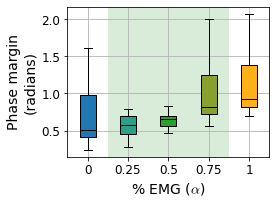

In [57]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

datas = [PM[:,0],PM[:,1],PM[:,2],PM[:,3],PM[:,4]]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_xlabel(r'% EMG ($\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel('Phase margin''\n''(radians)',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [58]:
WilcoxonTest(datas)

(array([nan, 49., 45., 25., 24., 49., nan, 26.,  0.,  0., 45., 26., nan,
         3.,  2., 25.,  0.,  3., nan, 54., 24.,  0.,  2., 54., nan]),
 array([           nan, 5.61401367e-01, 4.21203613e-01, 4.79125977e-02,
        4.12597656e-02, 5.61401367e-01,            nan, 5.53588867e-02,
        6.10351562e-05, 6.10351562e-05, 4.21203613e-01, 5.53588867e-02,
                   nan, 3.05175781e-04, 1.83105469e-04, 4.79125977e-02,
        6.10351562e-05, 3.05175781e-04,            nan, 7.61535645e-01,
        4.12597656e-02, 6.10351562e-05, 1.83105469e-04, 7.61535645e-01,
                   nan]),
 array([nan,  0.,  0.,  1.,  1.,  0., nan,  0.,  1.,  1.,  0.,  0., nan,
         1.,  1.,  1.,  1.,  1., nan,  0.,  1.,  1.,  1.,  0., nan]),
 ['there is significant difference between condition 0 and condition 3, w = 25.0, pvalue = 0.04791259765625',
  'there is significant difference between condition 0 and condition 4, w = 24.0, pvalue = 0.041259765625',
  'there is significant difference bet

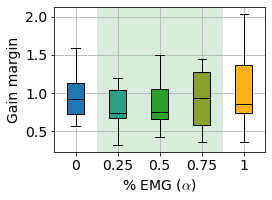

In [311]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

datas = [GM[:,0],GM[:,1],GM[:,2],GM[:,3],GM[:,4]]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_xlabel(r'% EMG ($\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel('Gain margin',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

# UCM

## UCM of F and B, stim freqs

In [10]:
def COMPLEX(i,argument): #real or imag part of complex numbers
    if argument == 'real':
        return np.real(i) 
    elif argument == 'imag':
        return np.imag(i) 
    
def variances(signal0, siganl1, cond, argument = 'real'): 
    Sigma = np.cov(COMPLEX(np.array([signal0,siganl1]),argument))
    # projection vectors for each condition         
    if cond == 2: #emg = 0.5
        E_ORT = np.array([1,1])
        E_UCM = np.array([1,-1])
    elif cond == 1: #emg = 0.25
        E_ORT = np.array([1,3])
        E_UCM = np.array([3,-1])
    elif cond == 3: #emg = 0.75
        E_ORT = np.array([3,1])
        E_UCM = np.array([1,-3])
    else:
        print('condition not found')

    k = (np.linalg.norm(E_ORT))**2 #dimension of the subspace

    #variance in (UCM) and (OTH) directions
    variance_ucm = 1/k *(E_UCM.T@Sigma@E_UCM) #normalized by dimension of subspace
    variance_ort = 1/k *(E_ORT.T@Sigma@E_ORT)            

    return variance_ucm,variance_ort

3.612733870581369 0.8486402149165612


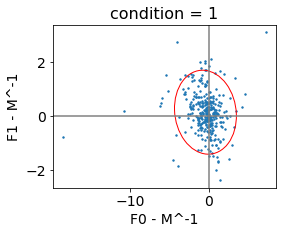

3.0412400725827107 1.608470967763727


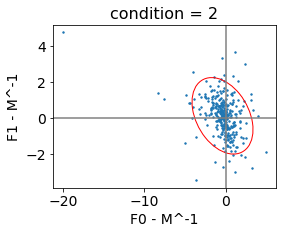

3.0308452684438802 1.885328722818286


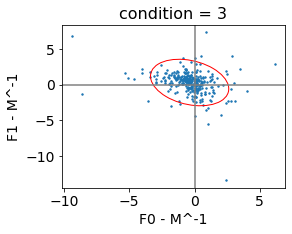

In [11]:
last_few_trials = 5 # cross trials (N//2)
lowest_freq = 1
for cond in [1,2,3]:
    fig,ax = plt.subplots(figsize=(4,3))
    xdim = []
    ydim = []
    for i in range(3): # lowest 3 stim freqs
        dim0 = []
        dim1 = []
        for sub in range(subject_num):
            dim0.append( (F0[sub,cond,:,i]-0.5*(M**(-1))[i]).real )
            dim1.append( (F1[sub,cond,:,i]-0.5*(M**(-1))[i]).real )
            # dim0.append( (F0[sub,cond,:,:lowest_freq] - 0.5*(M**(-1))[:lowest_freq]).real )
            # dim1.append( (F1[sub,cond,:,:lowest_freq] - 0.5*(M**(-1))[:lowest_freq]).real )
        xdim.append(np.array(dim0).flatten())
        ydim.append(np.array(dim1).flatten())
    xdim = np.concatenate(xdim)
    ydim = np.concatenate(ydim)
    ax.scatter(xdim,ydim,s = 2)
    confidence_ellipse(xdim,ydim, ax, edgecolor='red',n_std=2.0)
    variance_ucm,variance_ort = variances(xdim,ydim,cond = cond, argument = 'real')
    print(variance_ucm,variance_ort)
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    # ax.set_xlim(-2,2)
    # ax.set_ylim(-2,2)
    ax.set_xlabel('F0 - M^-1')
    ax.set_ylabel('F1 - M^-1')
    ax.set_title('condition = '+str(cond))  
    plt.show()

12.205706880349418 1.694704641937322


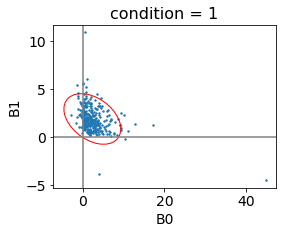

7.994623571549221 3.402667983942666


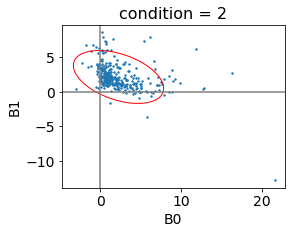

8.361141191658078 3.9665498540749304


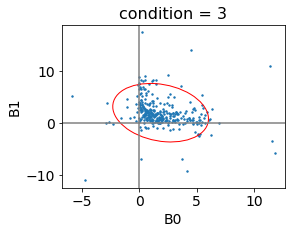

In [318]:
last_few_trials = 7 # cross trials (N//2)
lowest_freq = 1
for cond in [1,2,3]:
    fig,ax = plt.subplots(figsize=(4,3))
    xdim = []
    ydim = []
    for i in range(3): # lowest 3 stim freqs
        dim0 = []
        dim1 = []
        for sub in range(subject_num):
            dim0.append( (B0[sub,cond,:,i]).real )
            dim1.append( (B1[sub,cond,:,i]).real )
            # dim0.append( (F0[sub,cond,:,:lowest_freq] - 0.5*(M**(-1))[:lowest_freq]).real )
            # dim1.append( (F1[sub,cond,:,:lowest_freq] - 0.5*(M**(-1))[:lowest_freq]).real )
        xdim.append(np.array(dim0).flatten())
        ydim.append(np.array(dim1).flatten())
    xdim = np.concatenate(xdim)
    ydim = np.concatenate(ydim)
    ax.scatter(xdim,ydim,s = 2)
    confidence_ellipse(xdim,ydim, ax, edgecolor='red',n_std=2.0)
    variance_ucm,variance_ort = variances(xdim,ydim,cond = cond, argument = 'real')
    print(variance_ucm,variance_ort)
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    # ax.set_xlim(-2,2)
    # ax.set_ylim(-2,2)
    ax.set_xlabel('B0')
    ax.set_ylabel('B1')
    ax.set_title('condition = '+str(cond))  
    plt.show()

## UCM of F and B

In [24]:
# F at stimulated freqs
last_few_trials = 5 # cross trials (N//2)
lowest_freq = 3
xdim = []
ydim = []
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        for i in range(lowest_freq): # lowest 3 stim freqs
            f0 = (F0[sub,cond,:,i]-0.5*(M**(-1))[i])
            f1 = (F1[sub,cond,:,i]-0.5*(M**(-1))[i])
            dim0.append( f0.real )
            dim1.append( f1.real )
    xdim.append(np.array(dim0).flatten())
    ydim.append(np.array(dim1).flatten())    
xdim = np.array(xdim)
ydim = np.array(ydim)

# B at stimulated freqs
last_few_trials = 5 # cross trials (N//2)
lowest_freq = 3
xdim_ = []
ydim_ = []
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        for i in range(lowest_freq): # lowest 3 stim freqs
            f0 = (B0[sub,cond,:,i]-0.5*(M**(-1))[i])
            f1 = (B1[sub,cond,:,i]-0.5*(M**(-1))[i])
            dim0.append( f0.real )
            dim1.append( f1.real )
    xdim_.append(np.array(dim0).flatten())
    ydim_.append(np.array(dim1).flatten())    
xdim_ = np.array(xdim_)
ydim_ = np.array(ydim_)

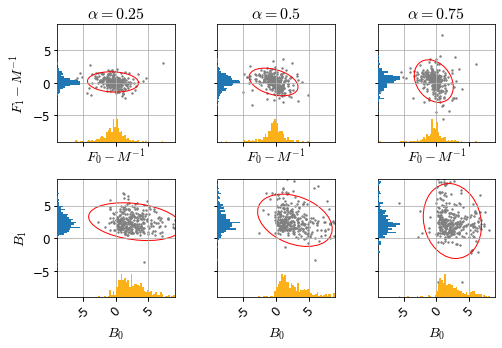

In [43]:
rcParams['mathtext.fontset'] = 'cm'
font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

fig,axs = plt.subplots(2,3,sharex=True, sharey=True,figsize=(7.5,5))
major_ticks = [-5, 0, 5]

PLOT0 = [xdim,xdim_]
PLOT1 = [ydim,ydim_]
# size = len(np.array(PLOT0[0]['condition'+str(c)]))
titles = [r'$\alpha=0.25$',r'$\alpha=0.5$',r'$\alpha=0.75$']
condition_order = [1,2,3]

# definitions for the axes
left, width = 0,1
bottom, height = 0,1
hist_height = 0.2 #historgram bin height
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom , width, hist_height]
rect_histy = [left, bottom, hist_height, height]

for i in range(2): #rows
    for j in range(3): #cols
        ax = axs[i,j]
        c = condition_order[j]
        x = np.array(PLOT0[i][j]).real
        y = np.array(PLOT1[i][j]).real
        confidence_ellipse(x,y, ax, edgecolor='red')

        ax.scatter(x,y,color = 'grey', s=2,label = 'condition'+str(c))

        #histograms
        ax_histx = ax.inset_axes(rect_histx, sharex=ax)
        ax_histy = ax.inset_axes(rect_histy, sharey=ax)
        # no labels
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)

        # now determine nice limits by hand:
        binwidth = 0.25 #0.0015
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        bins = np.arange(-lim, lim + binwidth, binwidth)
        if c != 5:
            ax_histx.hist(x, bins=bins,color=colors['GOLD'])
        if c != 6:
            ax_histy.hist(y, bins=bins, orientation='horizontal',color=colors['BLUE'])

        # ax.set_facecolor('none')
        ax_histx.set_facecolor('none')
        ax_histy.set_facecolor('none')

        ax_histx.spines['top'].set_visible(False)
        ax_histx.spines['right'].set_visible(False)
        ax_histx.spines['bottom'].set_visible(False)
        ax_histx.spines['left'].set_visible(False)
        ax_histy.spines['top'].set_visible(False)
        ax_histy.spines['right'].set_visible(False)
        ax_histy.spines['bottom'].set_visible(False)
        ax_histy.spines['left'].set_visible(False)

        ax_histx.set(yticks=[])
        ax_histy.set(xticks=[])

        ax.set_xlim(-9,9)
        ax.set_ylim(-9,9)
        ax.set_aspect('equal')
        ax.grid()
        ax.set_xticks(major_ticks)
        ax.set_xticklabels(major_ticks,rotation=45) 
    axs[i,0].set_yticks(major_ticks)

for j in range(3): #cols
    axs[0,j].title.set_text(titles[j])
    axs[0,j].set_xlabel(r'$F_0 - M^{-1}$',fontsize = 14)
    axs[1,j].set_xlabel(r'$B_0$',fontsize = 14)
    
axs[0,0].set_ylabel(r'$F_1 - M^{-1}$',fontsize = 14)
axs[1,0].set_ylabel(r'$B_1$',fontsize = 14)
plt.tight_layout()
plt.show()

## UCM, inputs at nonstim freqs

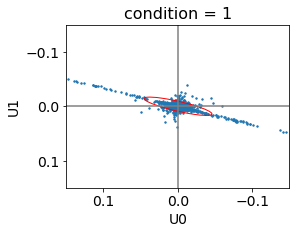

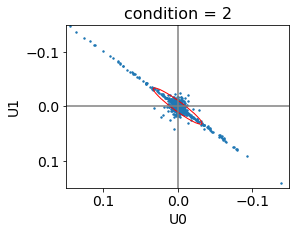

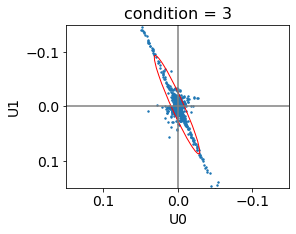

In [452]:
last_few_trials = 7 # cross trials (N//2)
lowest_freq = 8 # non-stimulus freqs below 0.25
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        dim0.append( (U0Xs[sub,cond,:,:lowest_freq]).real )
        dim1.append( (U1Xs[sub,cond,:,:lowest_freq]).real )
        # plt.scatter(F0[sub,cond,-4:,:2],F1[sub,cond,-4:,:2])
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    fig,ax = plt.subplots(figsize=(4,3))
    ax.scatter(dim0,dim1,s = 2)
    confidence_ellipse(dim0,dim1, ax, edgecolor='red')
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    ax.set_xlim(0.15,-0.15)
    ax.set_ylim(0.15,-0.15)
    ax.set_xlabel('UX0')
    ax.set_ylabel('UX1')
    ax.set_title('condition = '+str(cond))  
    plt.show()

## UCM at stim freqs

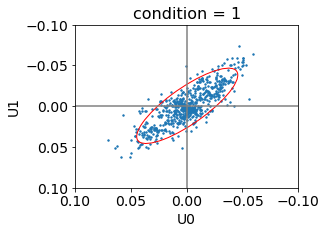

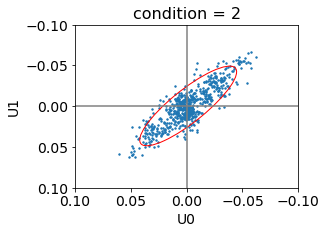

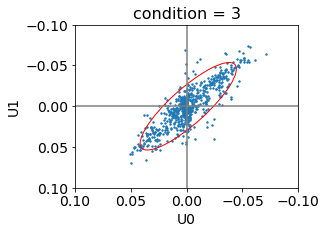

In [458]:
last_few_trials = 7 # cross trials (N//2)
lowest_freq = 3
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = U0s[sub,cond,:,:][:,IX[:lowest_freq]] - (M[:lowest_freq]**(-1)*Rs[sub,cond,:,:][:,IX[:lowest_freq]]-Ds[sub,cond,:,:][:,IX[:lowest_freq]])
        u1 = U1s[sub,cond,:,:][:,IX[:lowest_freq]] - (M[:lowest_freq]**(-1)*Rs[sub,cond,:,:][:,IX[:lowest_freq]]-Ds[sub,cond,:,:][:,IX[:lowest_freq]])
        dim0.append( u0.real )
        dim1.append( u1.real )
        # plt.scatter(F0[sub,cond,-4:,:2],F1[sub,cond,-4:,:2])
    dim0 = np.array(dim0).flatten()
    dim1 = np.array(dim1).flatten()
    fig,ax = plt.subplots(figsize=(4,3))
    ax.scatter(dim0,dim1,s = 2)
    confidence_ellipse(dim0,dim1, ax, edgecolor='red')
    ax.axvline(x = 0,color = 'grey')
    ax.axhline(y = 0,color = 'grey')
    ax.set_xlim(0.1,-0.1)
    ax.set_ylim(0.1,-0.1)
    ax.set_xlabel('U0')
    ax.set_ylabel('U1')
    ax.set_title('condition = '+str(cond))  
    plt.show()

## UCM of inputs

In [19]:
nonstim_freqs[nonstim_freqs <= 0.25]

array([0.   , 0.025, 0.05 , 0.075, 0.125, 0.175, 0.2  , 0.225])

In [105]:
# stimulated freqs
last_few_trials = 7 # cross trials (N//2)
lowest_freq = 3
xdim = []
ydim = []
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = U0s[sub,cond,:,:][:,IX[:lowest_freq]] - (M[:lowest_freq]**(-1)*Rs[sub,cond,:,:][:,IX[:lowest_freq]]-Ds[sub,cond,:,:][:,IX[:lowest_freq]])
        u1 = U1s[sub,cond,:,:][:,IX[:lowest_freq]] - (M[:lowest_freq]**(-1)*Rs[sub,cond,:,:][:,IX[:lowest_freq]]-Ds[sub,cond,:,:][:,IX[:lowest_freq]])
        dim0.append( u0.imag )
        dim1.append( u1.imag )
    xdim.append(np.array(dim0).flatten())
    ydim.append(np.array(dim1).flatten())    
xdim = np.array(xdim)
ydim = np.array(ydim)

# non stimulus freqs
last_few_trials = 7 # cross trials (N//2)
lowest_freq = 8 # non-stimulus freqs below 0.25
xdim_ = []
ydim_ = []
for cond in [1,2,3]:
    dim0 = []
    dim1 = []
    for sub in range(subject_num):
        u0 = U0Xs[sub,cond,:,:lowest_freq]
        u1 = U1Xs[sub,cond,:,:lowest_freq]
        dim0.append( u0.imag )
        dim1.append( u1.imag )
    xdim_.append(np.array(dim0).flatten())
    ydim_.append(np.array(dim1).flatten())    
xdim_ = np.array(xdim_)
ydim_ = np.array(ydim_)

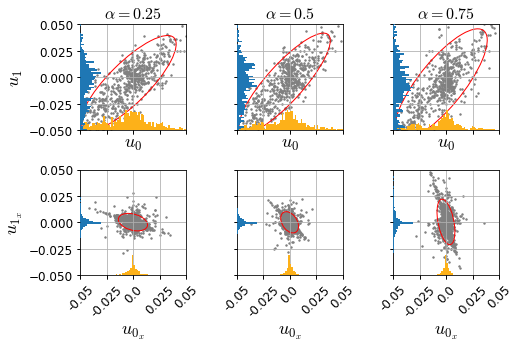

In [106]:
rcParams['mathtext.fontset'] = 'cm'
font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

fig,axs = plt.subplots(2,3,sharex=True, sharey=True,figsize=(7.5,5))
major_ticks = [-0.025,-0.05,0.,0.025,0.05]

PLOT0 = [xdim,xdim_]
PLOT1 = [ydim,ydim_]
# size = len(np.array(PLOT0[0]['condition'+str(c)]))
titles = [r'$\alpha=0.25$',r'$\alpha=0.5$',r'$\alpha=0.75$']
condition_order = [1,2,3]

# definitions for the axes
left, width = 0,1
bottom, height = 0,1
hist_height = 0.2 #historgram bin height
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom , width, hist_height]
rect_histy = [left, bottom, hist_height, height]

for i in range(2): #rows
    for j in range(3): #cols
        ax = axs[i,j]
        c = condition_order[j]
        x = np.array(PLOT0[i][j])
        y = np.array(PLOT1[i][j])
        confidence_ellipse(x,y, ax, edgecolor='red')

        ax.scatter(x,y,color = 'grey', s=2,label = 'condition'+str(c))

        #histograms
        ax_histx = ax.inset_axes(rect_histx, sharex=ax)
        ax_histy = ax.inset_axes(rect_histy, sharey=ax)
        # no labels
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)

        # now determine nice limits by hand:
        binwidth = 0.0015
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        bins = np.arange(-lim, lim + binwidth, binwidth)
        if c != 5:
            ax_histx.hist(x, bins=bins,color=colors['GOLD'])
        if c != 6:
            ax_histy.hist(y, bins=bins, orientation='horizontal',color=colors['BLUE'])

        # ax.set_facecolor('none')
        ax_histx.set_facecolor('none')
        ax_histy.set_facecolor('none')

        ax_histx.spines['top'].set_visible(False)
        ax_histx.spines['right'].set_visible(False)
        ax_histx.spines['bottom'].set_visible(False)
        ax_histx.spines['left'].set_visible(False)
        ax_histy.spines['top'].set_visible(False)
        ax_histy.spines['right'].set_visible(False)
        ax_histy.spines['bottom'].set_visible(False)
        ax_histy.spines['left'].set_visible(False)

        ax_histx.set(yticks=[])
        ax_histy.set(xticks=[])

        ax.set_xlim(-0.05,0.05)
        ax.set_ylim(-0.05,0.05)
        ax.set_aspect('equal')
        ax.grid()
        ax.set_xticks(major_ticks)
        ax.set_xticklabels(major_ticks,rotation=45) 
    axs[i,0].set_yticks(major_ticks)

for j in range(3): #cols
    axs[0,j].title.set_text(titles[j])
    axs[0,j].set_xlabel(r'$u_0$',fontsize = 18)
    axs[1,j].set_xlabel(r'$u_{0_x}$',fontsize = 18)
    
axs[0,0].set_ylabel(r'$u_1$',fontsize = 18)
axs[1,0].set_ylabel(r'$u_{1_x}$',fontsize = 18)
plt.tight_layout()
plt.show()